# Setup

---
#### Only run the `Setup` section if you want to evaluate the model by yourself. If you want to only check the comparisons, go to the `Comparison` section below.
---

## Step-by-Step Guide for Anaconda Setup

To ensure compatibility and avoid package conflicts, it's recommended to create a new conda environment with a specific Python version. Here are the steps to do this:

### 1. Install Anaconda
First, if you don't already have Conda installed, you'll need to install either Miniconda or Anaconda:

- [Download Anaconda](https://www.anaconda.com/products/distribution)

### 2. Create a New Conda Environment
1. Open your terminal or command prompt.
2. Create a new environment with Python 3.8:
    ```sh
    conda create -n FAC python=3.8
    ```
3. Activate the new environment:
    ```sh
    conda activate FAC
    ```

## Facer
After setting up your Anaconda environment, ensure that you have the proper models working and running for inference.

### Install Facer
1. Install Git LFS (Git Large File Storage) before proceeding:
    - **macOS**:
        ```sh
        brew install git-lfs
        ```
    - **Linux**:
        ```sh
        sudo apt-get install git-lfs
        ```
    - **Windows**: 
        - Download the installer from the [Git LFS website](https://git-lfs.github.com/).
    
    - After installing Git LFS, initialize it:
        ```sh
        git lfs install
        ```
2. Facer installation will handle the installation of the required packages for the facer program

In [ ]:
pip install git+https://github.com/FacePerceiver/facer.git@main

## Warning!

Facer is [CUDA](https://docs.nvidia.com/cuda/doc/index.html) dependent and it means that users without a NVIDIA GPU won't be able to run the code unless you provide changes in facer native file 'classification.py': 
1. at line **62** from `self.cuda().float()` to `self.cpu().float()`
2. at line **141** from `model.cuda()` to `model.cpu()`

## Dataset classification results extraction script (takes around 12h)

In [3]:
import facer
import os
import zipfile
import torch
import pandas as pd

def extract_zip(zip_file):
    img_dir = os.path.splitext(zip_file)[0]
    
    if not os.path.exists(img_dir):
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(zip_file))
        print(f"Extracted {zip_file}")
    else:
        print(f"{img_dir} already exists. Skipping extraction.")

    return img_dir

device = "cpu"

zip_file = "../img_align_celeba.zip" 
image_dir = extract_zip(zip_file)

face_detector = facer.face_detector("retinaface/mobilenet", device=device)
face_attr = facer.face_attr("farl/celeba/224", device=device)

results = []

images = os.listdir(image_dir)

for img_file in images:
    if img_file.endswith('.jpg'):
        img_path = os.path.join(image_dir, img_file)
        
        # Read and process image
        image = facer.hwc2bchw(facer.read_hwc(img_path)).to(device=device)
        
        with torch.inference_mode():        
            faces = face_detector(image)   
            
            if faces['image_ids'].shape[0] == 0:
                print(f"No faces detected in {img_file}")
                continue
            
            faces = face_attr(image, faces)
        
        labels = face_attr.labels
        
        for i, face_attrs in enumerate(faces["attrs"]):
            face_data = {"image": img_file}
            for prob, label in zip(face_attrs, labels):
                face_data[label] = prob.item()
            results.append(face_data) 
    
df = pd.DataFrame(results)

output_csv = "../facer_celeba_results.csv"
df.to_csv(output_csv, index=False)

print(f"Saved face attributes to {output_csv}")

## SwinFace

1. Replace `inference.py` file in locally cloned SwinFace with provided `scripts\inference.py` and run `python3 inference.py` in the cloned SwinFace repository folder **(takes around 12h)**.
2. Move the obtained `result.csv` into a predecessing folder for this repository.
3. Adjust the `result.csv` obtained from running the `inference.py` on CelebA dataset by execting below cell.

In [ ]:
import pandas as pd

def reorder_columns(input_file_path, output_file_path):
    df = pd.read_csv(input_file_path)

    # Replace spaces with underscores in column names
    df.columns = [col.replace(' ', '_') for col in df.columns]
    
    # Rename columns with special characters and amibiguities
    df = df.rename(columns={
        'Gender': 'Male',
        "Five_O'Clock_Shadow": "5_o_Clock_Shadow"
    })
    
    new_column_order = [
        "image", "5_o_Clock_Shadow", "Arched_Eyebrows", "Attractive", "Bags_Under_Eyes", "Bald", "Bangs", 
        "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair", "Blurry", "Brown_Hair", "Bushy_Eyebrows", 
        "Chubby", "Double_Chin", "Eyeglasses", "Goatee", "Gray_Hair", "Heavy_Makeup", "High_Cheekbones", 
        "Male", "Mouth_Slightly_Open", "Mustache", "Narrow_Eyes", "No_Beard", "Oval_Face", "Pale_Skin", 
        "Pointy_Nose", "Receding_Hairline", "Rosy_Cheeks", "Sideburns", "Smiling", "Straight_Hair", 
        "Wavy_Hair", "Wearing_Earrings", "Wearing_Hat", "Wearing_Lipstick", "Wearing_Necklace", 
        "Wearing_Necktie", "Young"
    ]

    df_reordered = df[new_column_order]
    df_reordered.to_csv(output_file_path, index=False)

input_file = '../result.csv'
output_file = '../swinface_celeba_results.csv'
reorder_columns(input_file, output_file)

## Ground Truth Labels
1. Load the `.txt` provided in CelebA dataset website.
2. Transform the `.txt` into a `.csv` file by executing below cell.

In [ ]:
import pandas as pd

def txt_to_csv(txt_file, csv_file):
    with open(txt_file, 'r') as file:
        lines = file.readlines()
    
    # Extract the header and data
    header = ["image"] + lines[0].strip().split()[1:]
    data = []
    for line in lines[1:]:
        parts = line.strip().split()
        data.append([parts[0]] + [int(x) for x in parts[1:]])

    df = pd.DataFrame(data, columns=header)

    df.to_csv(csv_file, index=False)

file_name = 'data/ground_truth_celeba'
txt_to_csv(f'{file_name}.txt', f'{file_name}.csv')

# Comparison

#### To have the smoothest experience of running the code provided below, I recommend downloading the `.csv` files attached here [Google Drive with .csv's](https://drive.google.com/drive/u/0/folders/1WhWUA6Cb_YZhUrp3EGimH3_XhOhUWn_o) as running the models on your local machine might be very resource costly and time consuming. You are welcome to save them wherever preffered but remember to adjust the paths in the cells below.

##### 1. First we load the files and libraries needed to perform comparisons

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc

In [12]:
facer_df = pd.read_csv('../facer_celeba_results.csv').sort_values('image').reset_index(drop=True)
swinface_df = pd.read_csv('../processed_swinface_celeba_results.csv').sort_values('image').reset_index(drop=True)
ground_truth_df = pd.read_csv('data/ground_truth_celeba.csv')

##### 2. As facer failed to recognize some faces and classify their attributes, to maintain fairness in evaluation we want to remove these faces from SwinFace results.

In [14]:
import pandas as pd

with open('data/not_detected_faces.txt', 'r') as file:
    lines = file.readlines()
    
# Extract image names, skipping the header lines
image_list = [line.strip() for line in lines[2:]]

image_set = set(image_list)

# Filter out the rows where 'image' is in the not_detected_faces list
filtered_swinface_df = swinface_df[~swinface_df['image'].isin(image_set)]

##### 3. Then for each of the attribute, we calculate statistics like:
- Accuracy
- ROC_AUC
- Precision
- Recall
- F1 Score 

In [15]:
merged_df = facer_df.merge(filtered_swinface_df, on='image', suffixes=('_facer', '_swinface')).merge(ground_truth_df, on='image')

# Exclude 'image' column
attributes = ground_truth_df.columns[1:]

stats = {
    'Attribute': [],
    'Accuracy_Facer': [],
    'Accuracy_Swinface': [],
    'ROC_AUC_Facer': [],
    'ROC_AUC_Swinface': [],
    'Precision_Facer': [],
    'Precision_Swinface': [],
    'Recall_Facer': [],
    'Recall_Swinface': [],
    'F1_Score_Facer': [],
    'F1_Score_Swinface': [],
}

for attr in attributes:
    # Ground truth labels (-1 and 1 converted to 0 and 1)
    y_true = (merged_df[attr] == 1).astype(int)
    # Facer predictions (rounded to 0 or 1)
    y_pred_facer = (merged_df[f'{attr}_facer'] > 0.5).astype(int)
    # Swinface predictions (rounded to 0 or 1)
    y_pred_swinface = (merged_df[f'{attr}_swinface'] > 0.5).astype(int)
    
    stats['Attribute'].append(attr)
    stats['Accuracy_Facer'].append(accuracy_score(y_true, y_pred_facer))
    stats['Accuracy_Swinface'].append(accuracy_score(y_true, y_pred_swinface))
    stats['ROC_AUC_Facer'].append(roc_auc_score(y_true, merged_df[f'{attr}_facer']))
    stats['ROC_AUC_Swinface'].append(roc_auc_score(y_true, merged_df[f'{attr}_swinface']))
    stats['Precision_Facer'].append(precision_score(y_true, y_pred_facer))
    stats['Precision_Swinface'].append(precision_score(y_true, y_pred_swinface))
    stats['Recall_Facer'].append(recall_score(y_true, y_pred_facer))
    stats['Recall_Swinface'].append(recall_score(y_true, y_pred_swinface))
    stats['F1_Score_Facer'].append(f1_score(y_true, y_pred_facer))
    stats['F1_Score_Swinface'].append(f1_score(y_true, y_pred_swinface))

stats_df = pd.DataFrame(stats)
stats_df.to_csv('data/comparison_statistics.csv', index=False)

##### 4. Now we calculate and plot overall stats

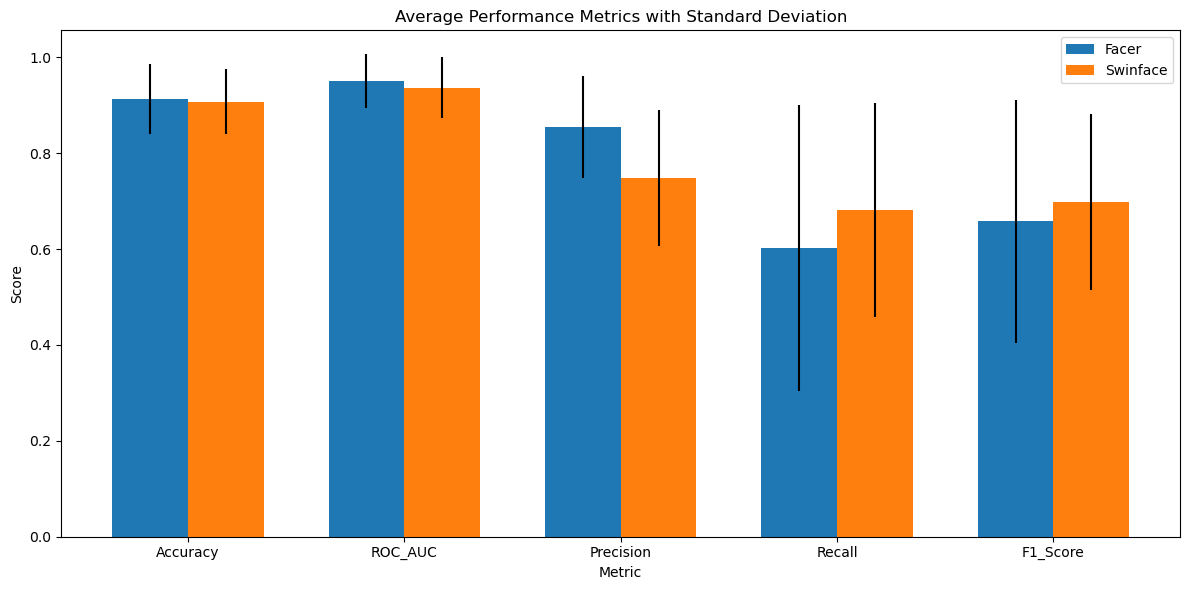

In [16]:
overall_stats = {
    'Metric': ['Accuracy', 'ROC_AUC', 'Precision', 'Recall', 'F1_Score'],
    'Facer_Avg': [
        stats_df['Accuracy_Facer'].mean(),
        stats_df['ROC_AUC_Facer'].mean(),
        stats_df['Precision_Facer'].mean(),
        stats_df['Recall_Facer'].mean(),
        stats_df['F1_Score_Facer'].mean()
    ],
    'Swinface_Avg': [
        stats_df['Accuracy_Swinface'].mean(),
        stats_df['ROC_AUC_Swinface'].mean(),
        stats_df['Precision_Swinface'].mean(),
        stats_df['Recall_Swinface'].mean(),
        stats_df['F1_Score_Swinface'].mean()
    ],
    'Facer_Std': [
        stats_df['Accuracy_Facer'].std(),
        stats_df['ROC_AUC_Facer'].std(),
        stats_df['Precision_Facer'].std(),
        stats_df['Recall_Facer'].std(),
        stats_df['F1_Score_Facer'].std()
    ],
    'Swinface_Std': [
        stats_df['Accuracy_Swinface'].std(),
        stats_df['ROC_AUC_Swinface'].std(),
        stats_df['Precision_Swinface'].std(),
        stats_df['Recall_Swinface'].std(),
        stats_df['F1_Score_Swinface'].std()
    ]
}

overall_stats_df = pd.DataFrame(overall_stats)

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(overall_stats_df))

plt.bar(index, overall_stats_df['Facer_Avg'], bar_width, label='Facer', yerr=overall_stats_df['Facer_Std'])
plt.bar(index + bar_width, overall_stats_df['Swinface_Avg'], bar_width, label='Swinface', yerr=overall_stats_df['Swinface_Std'])

plt.xlabel('Metric')
plt.ylabel('Score')
plt.title('Average Performance Metrics with Standard Deviation')
plt.xticks(index + bar_width / 2, overall_stats_df['Metric'])
plt.legend()

plt.tight_layout()
plt.savefig('performance_metrics_comparison.png')
plt.show()

##### 5. We want to see the ROC curve and ROC area for every attribute

In [47]:
n_rows = 8
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))
axes = axes.flatten()

# Loop through each attribute and plot on a subplot
for i, attribute in enumerate(attributes):
    y_true = (merged_df[attribute] == 1).astype(int)
    y_scores_facer = merged_df[f'{attribute}_facer']
    y_scores_swinface = merged_df[f'{attribute}_swinface']
    
    # Compute ROC curve and ROC area for both Facer and SwinFace
    fpr_facer, tpr_facer, _ = roc_curve(y_true, y_scores_facer)
    roc_auc_facer = auc(fpr_facer, tpr_facer)
    fpr_swinface, tpr_swinface, _ = roc_curve(y_true, y_scores_swinface)
    roc_auc_swinface = auc(fpr_swinface, tpr_swinface)
    
    # Plot ROC curve
    ax = axes[i]
    ax.plot(fpr_facer, tpr_facer, color='blue', lw=2, label=f'Facer (AUC = {roc_auc_facer:.2f})')
    ax.plot(fpr_swinface, tpr_swinface, color='red', lw=2, label=f'Swinface (AUC = {roc_auc_swinface:.2f})')
    ax.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('FPR', fontsize=12)
    ax.set_ylabel('TPR', fontsize=12)
    ax.set_title(attribute, fontsize=20)
    ax.grid()
    ax.legend(loc="lower right", fontsize=14)

plt.tight_layout()
plt.savefig('all_roc_curves.pdf', bbox_inches='tight')
plt.show()

##### 6. We compare and calculate the average accuracy that is based on comparison of ground truth labels with actual predicitons

In [46]:
file_path = 'data/comparison_statistics.csv'
comparison_df = pd.read_csv(file_path)

averages = comparison_df.mean(numeric_only=True)
averages['Attribute'] = 'Average'

averages_df = pd.DataFrame(averages).T
comparison_df = pd.concat([comparison_df, averages_df], ignore_index=True)

columns_of_interest = ['Attribute', 'Accuracy_Facer', 'Accuracy_Swinface']

results_df = comparison_df[columns_of_interest]
results_df.loc[:, ['Accuracy_Facer', 'Accuracy_Swinface']] = results_df.loc[:, ['Accuracy_Facer', 'Accuracy_Swinface']] * 100
results_df

,Attribute,Accuracy_Facer,Accuracy_Swinface
0,5_o_Clock_Shadow,93.818261,93.375368
1,Arched_Eyebrows,77.752651,82.80568
2,Attractive,83.633204,81.631051
3,Bags_Under_Eyes,83.746766,82.459562
4,Bald,99.132977,99.00707
5,Bangs,96.1453,95.845101
6,Big_Lips,78.297257,76.217092
7,Big_Nose,84.057828,80.486047
8,Black_Hair,91.689708,89.987755
9,Blond_Hair,96.012976,95.061027
